# Multiclass segmentation with the Lovász-Softmax
## Tensorflow version, see PyTorch version for more details & use in training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [33]:
import tensorflow as tf

In [4]:
import lovasz_losses_tf as L

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# add parent path to pythonpath to import demo_utils
import sys
sys.path.append('../demo_helpers')
from demo_utils import pil_grid, dummy_triangles, printoptions
from demo_utils_tf import define_scope

In [7]:
# add pytorch folder to path for comparison
sys.path.append('../pytorch')
import lovasz_losses as L_pytorch

## Batch of 2 random images with classes [0, 1, 2] and void (255)

### Labels

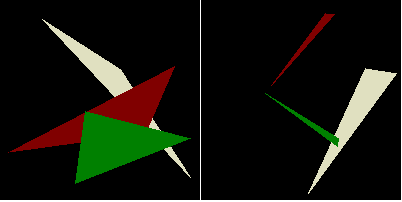

In [8]:
np.random.seed(18)
IGNORE = 255
C = 3
B = 2
H = 200
labels_ = [dummy_triangles(H, [0, 255, 1, 2]) for b in range(B)]
labels = np.stack(map(np.array, labels_)).astype(np.uint8)
pil_grid(labels_, 5, margin=1)

### Features

In [9]:
np.random.seed(57)
B, H, W = labels.shape
labels_ = labels.copy()
labels_[labels_ == 255] = np.random.randint(C, size=labels_.shape)[labels_ == 255] # random feats for void
labels_1hot = np.zeros((B, C, H, W))
for (b, h, w), c in np.ndenumerate(labels_):
    labels_1hot[b, c, h, w] = 1

In [10]:
feats = labels_1hot.copy()
feats += np.random.normal(0, 2, size=feats.shape)

## Model

### PyTorch reference

In [11]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn
import lovasz_losses as L_pytorch

class ModelPytorch(nn.Module):
    def __init__(self):
        super(ModelPytorch, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, padding=1)
        
    def forward(self, x):
        return x + self.conv(x)

m_torch = ModelPytorch().cuda()
out = m_torch(Variable(torch.from_numpy(feats.astype(np.float32)).cuda()))
out = F.softmax(out)
loss_torch = L_pytorch.lovasz_softmax(out, torch.from_numpy(labels).cuda(),
                                      only_present=True, ignore=IGNORE, per_image=False)

In [16]:
with printoptions(precision=4, suppress=True):
    print(out[0, 0, :10, :10].data.cpu().numpy())

[[0.3355 0.2288 0.7424 0.0829 0.8521 0.0757 0.0143 0.8725 0.5713 0.4565]
 [0.4779 0.8647 0.5776 0.0321 0.4146 0.0143 0.6375 0.8737 0.6001 0.8027]
 [0.9806 0.0528 0.0015 0.671  0.0095 0.9874 0.7075 0.0039 0.2106 0.987 ]
 [0.0802 0.9387 0.7126 0.5766 0.0362 0.9507 0.0004 0.0969 0.9088 0.9337]
 [0.6104 0.0255 0.0414 0.2045 0.9676 0.8938 0.6495 0.1372 0.0686 0.1333]
 [0.0665 0.0721 0.9964 0.9284 0.7498 0.382  0.0924 0.1466 0.4221 0.9914]
 [0.2396 0.1232 0.2587 0.0093 0.017  0.9666 0.0502 0.0859 0.7002 0.1966]
 [0.6159 0.6652 0.0074 0.4776 0.8972 0.6777 0.2861 0.4919 0.7389 0.354 ]
 [0.8986 0.9128 0.0385 0.9902 0.549  0.8943 0.2148 0.2527 0.874  0.3742]
 [0.0492 0.2115 0.0074 0.0697 0.7794 0.0197 0.0046 0.0268 0.0148 0.2851]]


In [17]:
loss_torch.data.cpu().numpy()[0]

0.7949457

#### small gradient check

In [18]:
loss_torch.backward()

In [19]:
m_torch.conv.bias.grad.data.cpu().numpy()

array([-0.04259117,  0.02204291,  0.02054827], dtype=float32)

### Tensorflow model definition

In [20]:
class Model:
    '''
    Simple linear model
    '''
    
    def __init__(self, feats):
        self.feats = feats
        self.scores
        self.predict

    @define_scope
    def scores(self):
        x = self.feats
        # replicate pytorch initialization
        init_weight = m_torch.conv.weight.data.cpu().numpy().transpose((2, 3, 1, 0))
        init_bias = m_torch.conv.bias.data.cpu().numpy()
        out = tf.nn.conv2d(x, tf.Variable(init_weight), strides=[1, 1, 1, 1], padding="SAME")
        out = tf.nn.bias_add(out, tf.Variable(init_bias))
        return x + out
    
    @define_scope
    def probas(self):
        return tf.nn.softmax(self.scores, 3)
    
    @define_scope
    def predict(self):
        return tf.argmax(self.scores, 3)

In [21]:
sess = tf.InteractiveSession()

In [22]:
labels_tf = tf.placeholder(np.int64, shape=(None, H, W), name='labels')
feats_tf = tf.placeholder(np.float32, shape=(None, H, W, C), name='features')

feed_dict = {labels_tf: labels, 
             feats_tf: feats.transpose(0, 2, 3, 1)}

In [23]:
m = Model(feats_tf)

In [24]:
sess.run(tf.global_variables_initializer())

In [25]:
loss = L.lovasz_softmax(m.probas, labels_tf, only_present=True,
                        ignore=IGNORE, per_image=False)

In [26]:
m.probas.eval(feed_dict).shape

(2, 200, 200, 3)

In [28]:
with printoptions(precision=4, suppress=True):
    print(m.probas.eval(feed_dict)[0, :10, :10, 0])

[[0.3355 0.2288 0.7424 0.0829 0.8521 0.0757 0.0143 0.8725 0.5713 0.4565]
 [0.4779 0.8647 0.5776 0.0321 0.4146 0.0143 0.6375 0.8737 0.6001 0.8027]
 [0.9806 0.0528 0.0015 0.671  0.0095 0.9874 0.7075 0.0039 0.2106 0.987 ]
 [0.0802 0.9387 0.7126 0.5766 0.0362 0.9507 0.0004 0.0969 0.9088 0.9337]
 [0.6104 0.0255 0.0414 0.2045 0.9676 0.8938 0.6495 0.1372 0.0686 0.1333]
 [0.0665 0.0721 0.9964 0.9284 0.7498 0.382  0.0924 0.1466 0.4221 0.9914]
 [0.2396 0.1232 0.2587 0.0093 0.017  0.9666 0.0502 0.0859 0.7002 0.1966]
 [0.6159 0.6652 0.0074 0.4776 0.8972 0.6777 0.2861 0.4919 0.7389 0.354 ]
 [0.8986 0.9128 0.0385 0.9902 0.549  0.8943 0.2148 0.2527 0.874  0.3742]
 [0.0492 0.2115 0.0074 0.0697 0.7794 0.0197 0.0046 0.0268 0.0148 0.2851]]


In [29]:
loss.eval(feed_dict)

0.7949457

#### Gradient w.r.t. bias

In [30]:
tf.trainable_variables()

[<tf.Variable 'scores/Variable:0' shape=(3, 3, 3, 3) dtype=float32_ref>,
 <tf.Variable 'scores/Variable_1:0' shape=(3,) dtype=float32_ref>]

In [32]:
tf.gradients(loss, tf.trainable_variables()[1])[0].eval(feed_dict)

array([-0.04259118,  0.02204292,  0.02054827], dtype=float32)